In [1]:
# Standard libraries
import pandas as pd
import numpy as np

from scipy.linalg import pinv
from scipy.stats import probplot # for QQ-plots
import statsmodels.formula.api as smf

# For data transformations
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import \
	StandardScaler, \
	OneHotEncoder, \
	MinMaxScaler, \
	PowerTransformer
from sklearn.compose import ColumnTransformer

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import \
	calculate_bartlett_sphericity, \
	calculate_kmo

# Custom tools for working with CBS data
import cbspython as cbs		

# My own collection of hacked-together tools for doing stats, generating 
# figures, manipulating dataframes, etc.
from wildpython import \
	wild_plots as wp, \
	wild_statsmodels as ws, \
	wild_sklearn as wsk, \
	wild_colors as wc, \
	chord_plot

# Helper packages that load parse and load the study data.
from cbsdata.covid_brain_study import CovidBrainStudy as CC
from cbsdata.sleep_study import SleepStudy as SS

# Plotly for plotting
import plotly
import plotly.express as px

# Display options for in this notebook
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(precision=3)

idx = pd.IndexSlice

def remove_unused_categories(df):
	""" Helper function to remove unused categories from all categorical columns
		in a dataframe. For use in chained pipelines.
	"""
	for col in df.select_dtypes('category').columns:
		df[col] = df[col].cat.remove_unused_categories()
	return df

nprev = 0
def report_N(df, label='', reset_count=False):
	""" Helper function to report the size of a dataframe in a pipeline chain.
		Optionally, will print a label. Useful for logging/debugging. If 
		reset_count is true, then the global counter (used to calculate change
		in sample size) is reset to zero.
	"""
	global nprev
	if reset_count:
		nprev = 0
	ncurrent = df.shape[0]
	delta = ncurrent - nprev
	print(f"N = {ncurrent:5d}, {delta:+6d} ({label})")
	nprev = df.shape[0]
	return df

def set_column_names(df, new_names):
	""" Another helper function that sets the columns of a dataframe to the 
		supplied new names (a list-like of names).
	"""
	df.columns = new_names
	return df

write_tables = False
write_images = False


 ## Control (Pre-Pandemic) Dataset
 ### Load & Preprocess Data

In [2]:
# Loads the control dataset from the (private) SS library
Yctrl = SS.score_data(datestamp="2021-01-28")

# List columns corresponding to "timing" (RT) features
tf  = cbs.timing_features(exclude=['spatial_planning']) # SP does not have one
tf_ = cbs.abbrev_features(tf)		# Abbreviated name

# List of columns corresponding to score features used in domain score calcs.
df  = cbs.domain_feature_list()
df_ = cbs.abbrev_features(df)

# A list of "all" available score features
af  = list(Yctrl.columns)
af_ = cbs.abbrev_features(af)
				
Xcovar = ['age', 'sex', 'post_secondary', 'SES']
correct_cols = [f"{test.abbrev}_num_correct" for _, test in cbs.TESTS.items()]

# Loads the control dataset (Sleep Study, 2017)
print("\nControl Scores:")
Yctrl = (Yctrl
	.pipe(set_column_names, af_)
	.reset_index('device_type')
	.groupby('user')
	.first()
	.pipe(report_N, "initial dataset", reset_count=True)
	.query('~(device_type in ["BOT", "CONSOLE", "MOBILE"])')
	.pipe(report_N, "drop unsupported devices")
	.reset_index().astype({'user': str})
	.set_index('user')
)

# Loads and organises the control questionnaire dataset
# Have to rename a few columns to match them up to the new study data
print("\nControl Questionnaires:")
Qctrl = (SS
	.questionnaire.data[['gender', 'age', 'education', 'SES_growing_up']]
	.reset_index().astype({'user': str})
	.set_index('user')
	.rename(columns={'gender': 'sex', 'SES_growing_up': 'SES'})
	.assign(post_secondary = lambda x: x.education >= "Bachelor's Degree")
	.pipe(report_N, "initial dataset", reset_count=True)
)

# Join the test scores (Yctrl) and the questionnaire data (Qctrl), then
# filter score columns to remove outliers (6 then 4 stdevs)
print("\nControl Dataset:")
Zctrl = (Yctrl
	.join(Qctrl[Xcovar], how='inner')
	.pipe(report_N, 'join datasets', reset_count=True)
	.query('(age >= 18) & (age <= 100)')
	.query('sex in ["Male", "Female"]')
	.pipe(report_N, 'filter age')
	.dropna()
	.query('&'.join([f"({c}>0)" for c in correct_cols]))
	.pipe(report_N, 'drop missing data')
	.pipe(ws.filter_df, subset=af_, sds=[6], drop=True)
	.pipe(report_N, '6 SD filter')
	.pipe(ws.filter_df, subset=af_, sds=[4], drop=True)
	.pipe(report_N, '4 SD filter')
	.dropna()
	.pipe(remove_unused_categories)
	.pipe(report_N, 'final')
)

# We'll use these in a table.
Yctrl_stats  = Zctrl[af_].agg(['mean', 'std'])

# Calculate mean and stdev for the score features, and remember them so we can 
# later apply these transformations to the test (CC) dataset.
Ytfm = Pipeline(steps=[
	('center', StandardScaler(with_mean=True, with_std=True)),
	('yeo', PowerTransformer(method='yeo-johnson'))
]).fit(Zctrl[af_].values)

# Z-scores the control test scores (all features)
Zctrl[af_] = Ytfm.transform(Zctrl[af_].values)



Control Scores:
N = 26256, +26256 (initial dataset)
N = 18424,  -7832 (drop unsupported devices)

Control Questionnaires:
N = 36538, +36538 (initial dataset)

Control Dataset:
N = 18423, +18423 (join datasets)
N = 16592,  -1831 (filter age)
N = 10156,  -6436 (drop missing data)
N =  9825,   -331 (6 SD filter)
N =  8815,  -1010 (4 SD filter)
N =  8815,     +0 (final)


 ### Factor Analysis (PCA) of CBS Test Scores (Control Group)

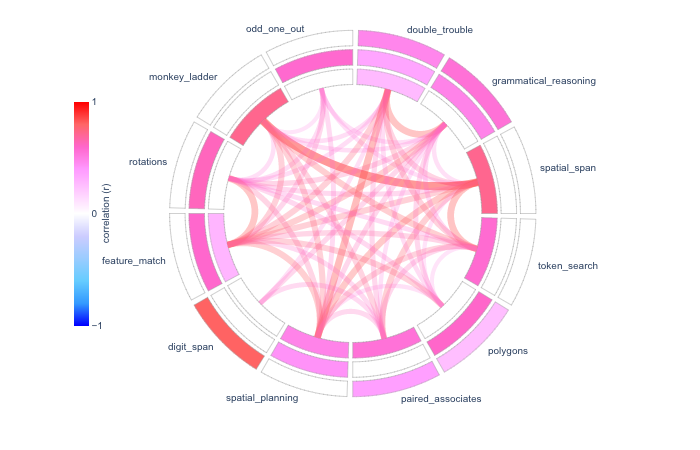

In [3]:
Ypca = FactorAnalyzer(
	method='principal',
	n_factors=3, 
	rotation='varimax').fit(Zctrl[df_])

# I know the scores turn out in this order....
pca_names = ['STM', 'reasoning', 'verbal']
loadings = pd.DataFrame(
	Ypca.loadings_, index=cbs.test_names(), columns=pca_names)
var_corrs = pd.DataFrame(
	Ypca.corr_, index=cbs.test_names(), columns=cbs.test_names())
eigen_values = pd.DataFrame(
	Ypca.get_eigenvalues()[0][0:3], index=pca_names, columns=['eigenvalues']).T
pct_variance = pd.DataFrame(
	Ypca.get_factor_variance()[1]*100, index=pca_names, columns=['% variance']).T

# Generates and displays the chord plot to visualize the factors
fig = chord_plot(
	loadings.copy(), var_corrs.copy(), 
	cscale_name='Picnic', width=700, height=350, threshold=0.20)
fig.write_image('./images/score_PCA.svg')

fig.show(renderer="png")
